# Smartwatch Shoulder Project
Code adapted from OrthoTron's "ArmTrack" project.

## Import Libraries

In [1]:
import sys
sys.version

import os
import csv
import random
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.linalg import norm
from scipy import misc

## Madgwick Implementation
From Jonas Böer, [Madgwick filter Python implementation](https://github.com/morgil/madgwick_py)

This is a good [explanation](https://nitinjsanket.github.io/tutorials/attitudeest/madgwick#:~:text=The%20Madgwick%20filter%20formulates%20the,obtained%20by%20the%20accelerometer%20measurements.) of the filter

In [2]:
"""
    Copyright (c) 2015 Jonas Böer, jonas.boeer@student.kit.edu

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import numpy as np
import numbers

class Quaternion:
    """
    A simple class implementing basic quaternion arithmetic.
    """
    def __init__(self, w_or_q, x=None, y=None, z=None):
        """
        Initializes a Quaternion object
        :param w_or_q: A scalar representing the real part of the quaternion, another Quaternion object or a
                    four-element array containing the quaternion values
        :param x: The first imaginary part if w_or_q is a scalar
        :param y: The second imaginary part if w_or_q is a scalar
        :param z: The third imaginary part if w_or_q is a scalar
        """
        self._q = np.array([1, 0, 0, 0])

        if x is not None and y is not None and z is not None:
            w = w_or_q
            q = np.array([w, x, y, z])
        elif isinstance(w_or_q, Quaternion):
            q = np.array(w_or_q.q)
        else:
            q = np.array(w_or_q)
            if len(q) != 4:
                raise ValueError("Expecting a 4-element array or w x y z as parameters")

        self.q = q

    # Quaternion specific interfaces

    def conj(self):
        """
        Returns the conjugate of the quaternion
        :rtype : Quaternion
        :return: the conjugate of the quaternion
        """
        return Quaternion(self._q[0], -self._q[1], -self._q[2], -self._q[3])

    def to_angle_axis(self):
        """
        Returns the quaternion's rotation represented by an Euler angle and axis.
        If the quaternion is the identity quaternion (1, 0, 0, 0), a rotation along the x axis with angle 0 is returned.
        :return: rad, x, y, z
        """
        if self[0] == 1 and self[1] == 0 and self[2] == 0 and self[3] == 0:
            return 0, 1, 0, 0
        rad = np.arccos(self[0]) * 2
        imaginary_factor = np.sin(rad / 2)
        if abs(imaginary_factor) < 1e-8:
            return 0, 1, 0, 0
        x = self._q[1] / imaginary_factor
        y = self._q[2] / imaginary_factor
        z = self._q[3] / imaginary_factor
        return rad, x, y, z

    @staticmethod
    def from_angle_axis(rad, x, y, z):
        s = np.sin(rad / 2)
        return Quaternion(np.cos(rad / 2), x*s, y*s, z*s)

    def to_euler_angles(self):
        pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
        if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
            roll = 0
            yaw = 2 * np.arctan2(self[1], self[0])
        elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
            roll = -2 * np.arctan2(self[1], self[0])
            yaw = 0
        else:
            roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
            yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
        return roll, pitch, yaw

    def to_euler123(self):
        roll = np.arctan2(-2 * (self[2] * self[3] - self[0] * self[1]), self[0] ** 2 - self[1] ** 2 - self[2] ** 2 + self[3] ** 2)
        pitch = np.arcsin(2 * (self[1] * self[3] + self[0] * self[1]))
        yaw = np.arctan2(-2 * (self[1] * self[2] - self[0] * self[3]), self[0] ** 2 + self[1] ** 2 - self[2] ** 2 - self[3] ** 2)
        return roll, pitch, yaw

    def __mul__(self, other):
        """
        multiply the given quaternion with another quaternion or a scalar
        :param other: a Quaternion object or a number
        :return:
        """
        if isinstance(other, Quaternion):
            w = self._q[0]*other._q[0] - self._q[1]*other._q[1] - self._q[2]*other._q[2] - self._q[3]*other._q[3]
            x = self._q[0]*other._q[1] + self._q[1]*other._q[0] + self._q[2]*other._q[3] - self._q[3]*other._q[2]
            y = self._q[0]*other._q[2] - self._q[1]*other._q[3] + self._q[2]*other._q[0] + self._q[3]*other._q[1]
            z = self._q[0]*other._q[3] + self._q[1]*other._q[2] - self._q[2]*other._q[1] + self._q[3]*other._q[0]

            return Quaternion(w, x, y, z)
        elif isinstance(other, numbers.Number):
            q = self._q * other
            return Quaternion(q)

    def __add__(self, other):
        """
        add two quaternions element-wise or add a scalar to each element of the quaternion
        :param other:
        :return:
        """
        if not isinstance(other, Quaternion):
            if len(other) != 4:
                raise TypeError("Quaternions must be added to other quaternions or a 4-element array")
            q = self._q + other
        else:
            q = self._q + other._q

        return Quaternion(q)

    # Implementing other interfaces to ease working with the class

    @property
    def q(self):
        return self._q

    @q.setter
    def q(self, q):
        self._q = q

    def __getitem__(self, item):
        return self._q[item]

    def __array__(self):
        return self._q

In [3]:
"""
    Copyright (c) 2015 Jonas Böer, jonas.boeer@student.kit.edu

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import warnings
# import numpy as np
from numpy.linalg import norm
# from .quaternion import Quaternion

class MadgwickAHRS:
    samplePeriod = 1/256
    quaternion = Quaternion(1, 0, 0, 0)
    beta = 1
    zeta = 0

    def __init__(self, sampleperiod=None, quaternion=None, beta=None, zeta=None):
        """
        Initialize the class with the given parameters.
        :param sampleperiod: The sample period
        :param quaternion: Initial quaternion
        :param beta: Algorithm gain beta
        :param beta: Algorithm gain zeta
        :return:
        """
        if sampleperiod is not None:
            self.samplePeriod = sampleperiod
        if quaternion is not None:
            self.quaternion = quaternion
        if beta is not None:
            self.beta = beta
        if zeta is not None:
            self.zeta = zeta

    def update(self, gyroscope, accelerometer, magnetometer):
        """
        Perform one update step with data from a AHRS sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        :param magnetometer: A three-element array containing the magnetometer data. Can be any unit since a normalized value is used.
        :return:
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()
        magnetometer = np.array(magnetometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Normalise magnetometer measurement
        if norm(magnetometer) is 0:
            warnings.warn("magnetometer is zero")
            return
        magnetometer /= norm(magnetometer)

        h = q * (Quaternion(0, magnetometer[0], magnetometer[1], magnetometer[2]) * q.conj())
        b = np.array([0, norm(h[1:3]), 0, h[3]])

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2],
            2*b[1]*(0.5 - q[2]**2 - q[3]**2) + 2*b[3]*(q[1]*q[3] - q[0]*q[2]) - magnetometer[0],
            2*b[1]*(q[1]*q[2] - q[0]*q[3]) + 2*b[3]*(q[0]*q[1] + q[2]*q[3]) - magnetometer[1],
            2*b[1]*(q[0]*q[2] + q[1]*q[3]) + 2*b[3]*(0.5 - q[1]**2 - q[2]**2) - magnetometer[2]
        ])
        j = np.array([
            [-2*q[2],                  2*q[3],                  -2*q[0],                  2*q[1]],
            [2*q[1],                   2*q[0],                  2*q[3],                   2*q[2]],
            [0,                        -4*q[1],                 -4*q[2],                  0],
            [-2*b[3]*q[2],             2*b[3]*q[3],             -4*b[1]*q[2]-2*b[3]*q[0], -4*b[1]*q[3]+2*b[3]*q[1]],
            [-2*b[1]*q[3]+2*b[3]*q[1], 2*b[1]*q[2]+2*b[3]*q[0], 2*b[1]*q[1]+2*b[3]*q[3],  -2*b[1]*q[0]+2*b[3]*q[2]],
            [2*b[1]*q[2],              2*b[1]*q[3]-4*b[3]*q[1], 2*b[1]*q[0]-4*b[3]*q[2],  2*b[1]*q[1]]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Gyroscope compensation drift
        gyroscopeQuat = Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])
        stepQuat = Quaternion(step.T[0], step.T[1], step.T[2], step.T[3])

        gyroscopeQuat = gyroscopeQuat + (q.conj() * stepQuat) * 2 * self.samplePeriod * self.zeta * -1

        # Compute rate of change of quaternion
        qdot = (q * gyroscopeQuat) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion

    def update_imu(self, gyroscope, accelerometer):
        """
        Perform one update step with data from a IMU sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2]
        ])
        j = np.array([
            [-2*q[2], 2*q[3], -2*q[0], 2*q[1]],
            [2*q[1], 2*q[0], 2*q[3], 2*q[2]],
            [0, -4*q[1], -4*q[2], 0]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion

<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-3-4d79a34b7757>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm(accelerometer) is 0:
<ipython-input-3-4d79a34b7757>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm(magnetometer) is 0:
<ipython-input-3-4d79a34b7757>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm(accelerometer) is 0:


## Dataloader

In [4]:
class DataLoader:
  def __init__(self, dataset,
               time_col="time",
               accel_col=['a_1','a_2','a_3'],
               gyro_col=['g_1','g_2','g_3'],
               magnet_col=['m_1','m_2','m_3']):
    """
    Initialize dataloader for recorded motion IMU data

    Passed in dataset should be in the form of a pandas dataframe, with the
    columns:
        time_col: the column with the time since start [s]
        accel_col: the column for the recorded accelerometer data
                   (tuple of x, y, z axes)
        gyro_col: the column for the recorded gyroscope data
                   (tuple of x, y, z axes)
        magnet_col: the column for the recorded magnetometer data
                   (tuple of x, y, z axes)

    At each iteration, the iterator returns a row in the form of a named tuple
    corresponding to a measurement for each sensor.
    The format of the data returned is:
        [x,y,z]: x,y,z measurements for indices [0, 1, 2], respectively
    """
    df_copy = dataset.copy(deep=True)
    df_copy = df_copy.rename(columns={time_col: "t"})
    df_copy.sort_values(by=["t"])

    self.time_data = iter(df_copy["t"])

    self.accel_data = df_copy[accel_col].itertuples(index=False, name="Accelerometer")

    self.gyro_data = df_copy[gyro_col].itertuples(index=False, name="Gyroscope")

    self.magnet_data = df_copy[magnet_col].itertuples(index=False, name="Magnetometer")

  def __iter__(self):
    return self

  def __next__(self):
    """Returns the next values of acceleration, gyroscope, and magnetometer"""

    a = next(self.accel_data, None)
    g = next(self.gyro_data, None)
    m = next(self.magnet_data, None)
    t = next(self.time_data, None)

    if a is None or g is None or m is None:
      raise StopIteration

    t_next = t
    a_next = np.array([a[0], a[1], a[2]]).reshape(3,1)
    g_next = np.array([g[0], g[1], g[2]]).reshape(3,1)
    m_next = np.array([m[0], m[1], m[2]]).reshape(3,1)

    return t_next, g_next, a_next, m_next

## Orientation Estimation Using Madgwick Filter

**Note**: The quaternions from the Madgwick filter represent the estimated Earth reference frame in the sensor's frame of reference

In [5]:
GRAVITY = -9.81 # Not used
SAMPLING_FREQUENCY = 50 # [Hz], assume samplied frequency of 50 Hz
SAMPLING_PERIOD = 1/SAMPLING_FREQUENCY # [s] For the IMU data

from scipy.spatial.transform import Rotation as R

def setup_madgwick(sampleperiod, initial_orientation=None, beta=None):
  """ The main purpose of this function is to return a closure """
  io = initial_orientation if initial_orientation is not None else Quaternion(1, 0, 0, 0)
  b = beta if beta is not None else 1
  madgwick = MadgwickAHRS(sampleperiod, io, b)

  def rawdata2_quaternion(g,a,m=None):
    """ Expects an iterable containing raw data at each time step """
    if m is not None:
      madgwick.update(g,a,m)
    else:
      madgwick.update_imu(g,a)
    q_se = madgwick.quaternion
    return q_se

  return rawdata2_quaternion

## Pre-processing Data
Define functions to filter the sensor measurements of a given trial data set.

In [6]:
# Save data into a csv
from pathlib import Path

def save_MF_data(df_temp, filename_temp, filepath_temp):
    from datetime import date
    date_temp = f"{date.today()}"

    folder_path = os.path.join(filepath_temp, date_temp)

    Path(folder_path).mkdir(parents=True, exist_ok=True)
    df_temp.to_csv(f"{filepath_temp}/{date_temp}/{filename_temp}_MF_imu.csv") # Rename file as needed

def apply_madgwick_filter(df_temp):
    '''Applies the Madgwick filter to the accelerometer, gyroscope, and
    magnetometer data '''
    orientation_temp = setup_madgwick(SAMPLING_PERIOD) # use 1/50 Hz
    time_temp        = [t for t,_,_,_ in DataLoader(df_temp)]
    quaternions_temp = [orientation_temp(g,a,m) for _,g,a,m in DataLoader(df_temp)] # Result from the madgwick filter
    acc_sensor_temp  = [a.reshape(3) for _,_,a,_ in DataLoader(df_temp)]
    acc_earth_temp   = [(q*Quaternion([0, a[0], a[1], a[2]])*q.conj()).q[1:].reshape(3)\
                        for q,a in zip(quaternions_temp, acc_sensor_temp)]

    # print(acc_earth_temp)
    # print(f"size: {len(acc_earth_temp)}")

    # Seems like gravity was already factored in an earlier step
    # acc_earth_minus_gravity_temp = [a + np.array([0,0,GRAVITY]).reshape(3)\
    #                               for a in acc_earth_temp]

    gyro_sensor_temp  = [g.reshape(3) for _,g,_,_ in DataLoader(df_temp)]
    gryo_corrected   = [(q*Quaternion([0, g[0], g[1], g[2]])*q.conj()).q[1:].reshape(3)\
                        for q,g in zip(quaternions_temp, gyro_sensor_temp)]

    mag_sensor_temp  = [m.reshape(3) for _,_,_,m in DataLoader(df_temp)]
    mag_corrected   = [(q*Quaternion([0, m[0], m[1], m[2]])*q.conj()).q[1:].reshape(3)\
                        for q,m in zip(quaternions_temp, mag_sensor_temp)]

    # Combined sensors
    df_imu_temp = pd.DataFrame({'a_1': [x for x,_,_ in acc_earth_temp],
                                'a_2': [y for _,y,_ in acc_earth_temp],
                                'a_3': [z for _,_,z in acc_earth_temp],
                                'm_1': [x for x,_,_ in mag_corrected],
                                'm_2': [y for _,y,_ in mag_corrected],
                                'm_3': [z for _,_,z in mag_corrected],
                                'g_1': [x for x,_,_ in gryo_corrected],
                                'g_2': [y for _,y,_ in gryo_corrected],
                                'g_3': [z for _,_,z in gryo_corrected],
                                'time': time_temp})

    return df_imu_temp

## Reading Data and Applying Filter

In [7]:
# Commented out: reading from Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Single File Sanity Check
Reading in IMU data in the form of `[a_1, a_2, a_3, m_1, m_2, m_3, g_1, g_2, g_3, time]`

In [9]:
# Reading in single file, for sanity check

subject_num = '01'
exercise_num = 1
shoulder = 'R'
trial = 1

filename = f"S{subject_num}_E{exercise_num}_{shoulder}_{trial}"
temp_path = f"E:/Datasets/0-Processed_Datasets/subjects_2023-07-12" # FILEPATH

# Reading in csv file
# unfiltered_data = pd.read_csv(f"/content/drive/My Drive/Smartwatch-Shoulder-Project/subjects_2023-07-12/{filename}_full 1.csv") # Google Drive path
unfiltered_data = pd.read_csv(f"{temp_path}/{filename}") # FILEPATH

df_unfiltered = unfiltered_data[['a_1', 'a_2', 'a_3', 'm_1', 'm_2', 'm_3', 'g_1', 'g_2', 'g_3', 'time']]

df_filtered = apply_madgwick_filter(df_unfiltered)

# save_path = f"/content/drive/My Drive/Smartwatch-Shoulder-Project/Madgwick-Filtered/"
save_path = f"E:/Datasets/0-Processed_Datasets/Madgwick-Filtered/" # FILEPATH

save_MF_data(df_filtered, filename, save_path) # save into csv

In [10]:
print("Unfiltered")
df_unfiltered

Unfiltered


,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,time
0,12.796875,-1.435059,5.046875,6.457031,-74.687500,-181.750000,0.547852,-0.923340,1.453125,0.000000
1,13.023438,-1.113037,4.687500,7.353516,-74.218750,-180.375000,0.537842,-0.676025,1.550781,0.020015
2,13.046875,-0.783691,4.064453,8.304688,-70.750000,-178.125000,0.536133,-0.255290,1.678060,0.040029
3,13.011719,-0.661865,3.271484,8.218750,-70.468750,-178.000000,0.526367,0.069153,1.752930,0.060044
4,12.921875,-0.469116,2.582031,9.054688,-69.395833,-179.041667,0.539307,0.313904,1.784180,0.080058
...,...,...,...,...,...,...,...,...,...,...
1375,12.625000,-1.161865,7.873047,65.187500,-0.399902,4.000000,-0.546875,-1.252441,-2.234375,27.519942
1376,13.253906,-1.614258,8.234375,66.062500,-1.899414,6.699219,-0.485229,-0.921143,-2.316406,27.539956
1377,13.824219,-1.631348,8.429688,65.437500,-5.048828,8.046875,-0.635742,-0.558594,-2.373047,27.559971
1378,13.691406,-2.416016,8.242188,65.343750,-6.998047,9.093750,-0.722900,-0.223938,-2.418945,27.579985


In [11]:
print("Filtered")
df_filtered # See dataframe

Filtered


,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,time
0,12.529470,-1.110610,5.750589,19.360670,-70.851257,-182.368424,0.495185,-0.933099,1.465738,0.000000
1,12.486653,-0.429431,6.059745,32.059975,-66.086137,-180.838099,0.413823,-0.701601,1.577249,0.020015
2,12.298635,0.302392,6.000585,42.630206,-58.069309,-177.802325,0.304429,-0.304989,1.727079,0.040029
3,12.138567,0.874755,5.686432,51.336622,-53.076093,-176.818755,0.179703,-0.009294,1.822698,0.060044
4,11.925362,1.526726,5.414486,59.929517,-46.856952,-176.540552,0.079498,0.207840,1.877010,0.080058
...,...,...,...,...,...,...,...,...,...,...
1375,-4.366506,6.111324,12.896153,10.763149,15.804980,62.449398,1.094866,-2.360734,-0.297183,27.519942
1376,-5.085785,5.455732,13.800238,6.304580,13.064397,64.825265,1.336811,-2.120102,-0.409626,27.539956
1377,-5.371860,4.974696,14.533598,2.175942,7.738483,65.632998,1.532805,-1.868316,-0.712357,27.559971
1378,-5.781014,3.558611,14.667705,-0.499810,3.299474,66.259628,1.718893,-1.615094,-0.927852,27.579985


## MAIN FUNCTION
Reading in all data and saving all data

In [12]:
# Define file structure as needed
FILE_TYPE = "full"
IMU_DATA_FOLDER = 'subjects_2023-07-12'
# DIRECTORY_IMU = f'/content/drive/My Drive/Smartwatch-Shoulder-Project/{IMU_DATA_FOLDER}/'
DIRECTORY_IMU = f'E:/Datasets/0-Processed_Datasets/{IMU_DATA_FOLDER}/' # FILEPATH

filepaths = []
filenames = [] # E.g. S01_E1_R_1_full.csv

df_all_trials = [] # Saving all input data trials into this

for f in os.listdir(DIRECTORY_IMU):
    if FILE_TYPE in f:
        filepaths.append(DIRECTORY_IMU + f)
        filenames.append(f)

filenames.sort()
filepaths.sort()

# Reading in csv files
for f in filepaths:
    df_all_trials.append(pd.read_csv(f))

# Taking the first half of the filename for saving in the future, e.g. S01_E1_R_1
filenames_short = []
for f in filenames:
    i_temp = f.rindex("_")
    filenames_short.append(f[0:i_temp])

filenames_short.sort()

# Read and apply Madgwick Filter to all files
# SAVE_FILEPATH = f"/content/drive/My Drive/Smartwatch-Shoulder-Project/Madgwick-Filtered/"
SAVE_FILEPATH = f"E:/Datasets/0-Processed_Datasets/Madgwick-Filtered/" # FILEPATH


for i in range(len(filenames)):
    imu_data_temp = df_all_trials[i]
    imu_data = imu_data_temp[['a_1', 'a_2', 'a_3', 'm_1', 'm_2', 'm_3', 'g_1', 'g_2', 'g_3', 'time']]

    df_imu = apply_madgwick_filter(imu_data)
    save_MF_data(df_imu, filenames_short[i], SAVE_FILEPATH) # save into csv

    print(f'\ni: {i}, {filenames_short[i]}')


i: 0, S01_E1_R_1

i: 1, S01_E1_R_2

i: 2, S01_E2_R_1

i: 3, S10_E5_R_1


## Data-Analysis
To validate the efficacy of the filter. Helper functions have all been defined. The code here looks at the earlier selected single trial as an example.



In [30]:
def get_statistics(name, data):
    ''' Get Statistics
    name: sensor component, e.g. a_1 for acceleration x component
    data: respective data for the sensor component
    '''
    mean = statistics.mean(data)
    std = statistics.stdev(data)

    print(f'\n{name} average mean: {mean} +/- {std}')
    return mean, std

from matplotlib import pyplot as plt
from scipy.stats import norm

def plot_normal_distribution(name, data):
    ''' Plot normal distribution
    name: sensor component, e.g. a_1 for acceleration x component
    data: respective data for the sensor component
    '''
    mu, sd = norm.fit(data) # Fit normal distribution to data
    print(f'mean: {mu}, std: +/-{sd}')

    plt.hist(data, bins=20, density=True, alpha=0.6) # Histogram, alpha: transparency

    xmin, xmax = plt.xlim()
    x_axis = np.arange(xmin, xmax, 0.001)
    plt.axvline(x = mu, color = 'green', label = 'axvline - full height')

    plt.plot(x_axis, norm.pdf(x_axis, mu, sd), color='r') # PDF
    plt.ylabel('Density')
    plt.xlabel(name)
    plt.show()

In [22]:
# After it's been filtered, look at the statistics over several trials of data
for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    _, _ = get_statistics(name, data_series)


a_1 average mean: 0.5051497729650866 +/- 4.894298924030102

a_2 average mean: -0.5714496677425848 +/- 5.275436698492464

a_3 average mean: 9.731769399286284 +/- 2.369309273181882

m_1 average mean: 27.10212525684255 +/- 26.542803808087506

m_2 average mean: -3.4970162747384674 +/- 26.869458795644455

m_3 average mean: 46.0734116191612 +/- 38.94229690116995

g_1 average mean: 0.04895847261936275 +/- 1.6746326427519291

g_2 average mean: -0.07011635023757262 +/- 1.5771569086616555

g_3 average mean: 0.027052894444067613 +/- 0.74732442821849


Note: `df_filtered` should be the same as `df_MF_data` (the saved file)

In [20]:
# Sanity check
# Reading in saved file for the earlier defined file. This should yield the same trial as df_filtered
date_folder = '2023-12-21' # Edit as needed

# df_MF_data = pd.read_csv(f"/content/drive/My Drive/Smartwatch-Shoulder-Project/Madgwick-Filtered/{date_folder}/{filename}_MF_imu.csv")
df_MF_data = pd.read_csv(f"E:/Datasets/0-Processed_Datasets/Madgwick-Filtered/{date_folder}/{filename}_MF_imu.csv") # FILEPATH

# Note, the first column by default saves as an index column. Don't include it that one.
df_MF_data = df_MF_data[['a_1', 'a_2', 'a_3', 'm_1', 'm_2', 'm_3', 'g_1', 'g_2', 'g_3', 'time']]

for name, data_series in df_MF_data[df_MF_data.columns[0:9]].items():
    _, _ = get_statistics(name, data_series)


a_1 average mean: 0.5051497729650866 +/- 4.894298924030102

a_2 average mean: -0.5714496677425849 +/- 5.275436698492464

a_3 average mean: 9.731769399286284 +/- 2.369309273181882

m_1 average mean: 27.10212525684255 +/- 26.542803808087506

m_2 average mean: -3.4970162747384674 +/- 26.869458795644455

m_3 average mean: 46.0734116191612 +/- 38.94229690116995

g_1 average mean: 0.04895847261936275 +/- 1.6746326427519291

g_2 average mean: -0.07011635023757262 +/- 1.5771569086616555

g_3 average mean: 0.027052894444067617 +/- 0.74732442821849


mean: 0.5051497729650865, std: +/-4.8925253059526455


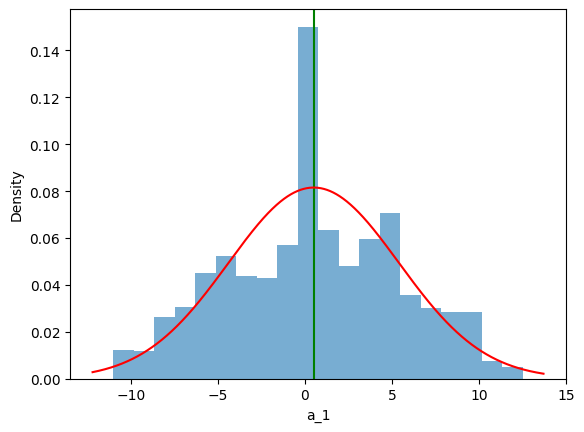

mean: -0.5714496677425848, std: +/-5.273524961992475


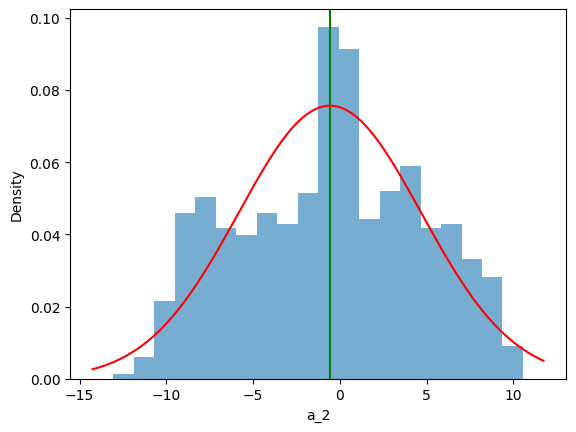

mean: 9.731769399286284, std: +/-2.3684506722212073


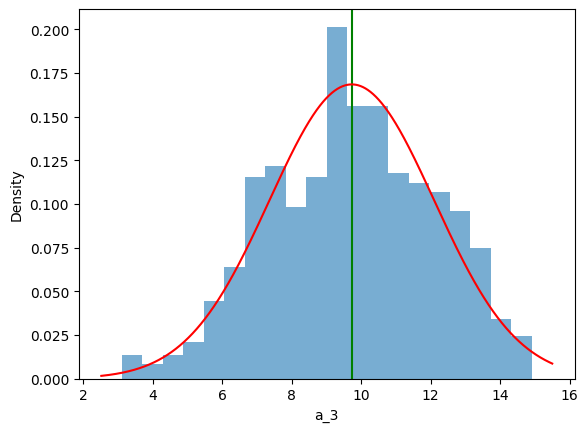

mean: 27.102125256842555, std: +/-26.533185107351986


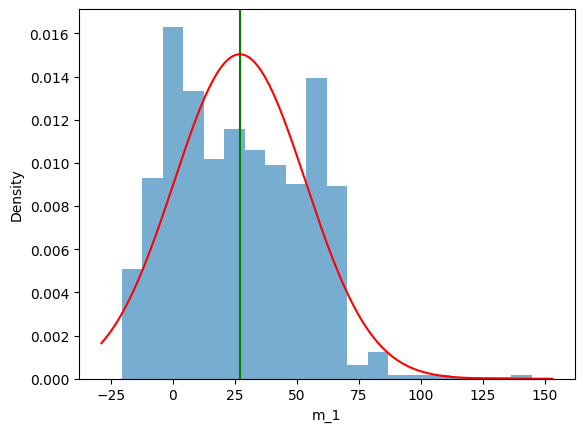

mean: -3.4970162747384674, std: +/-26.859721720203993


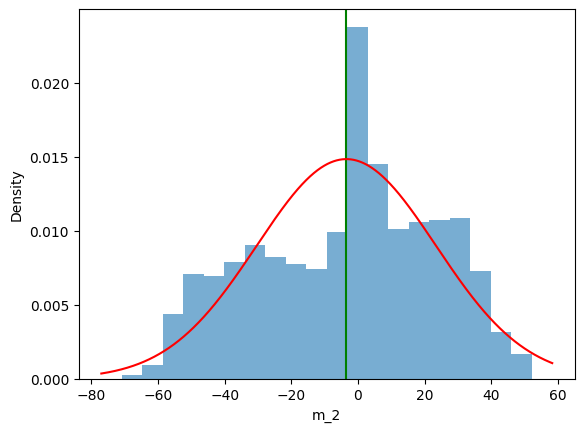

mean: 46.0734116191612, std: +/-38.92818481630679


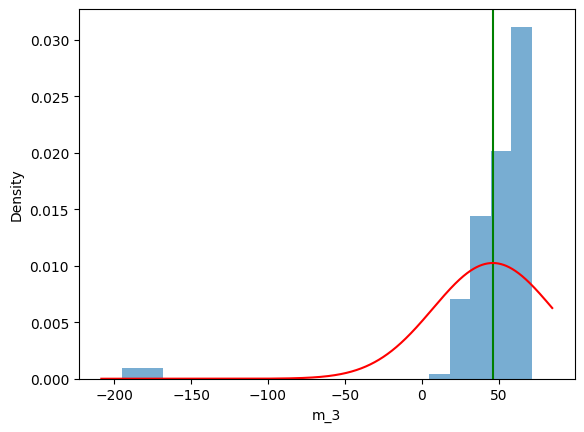

mean: 0.04895847261936275, std: +/-1.6740257818359148


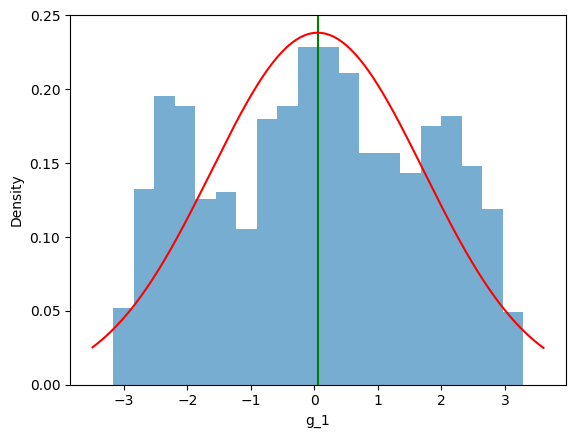

mean: -0.07011635023757262, std: +/-1.5765853714409814


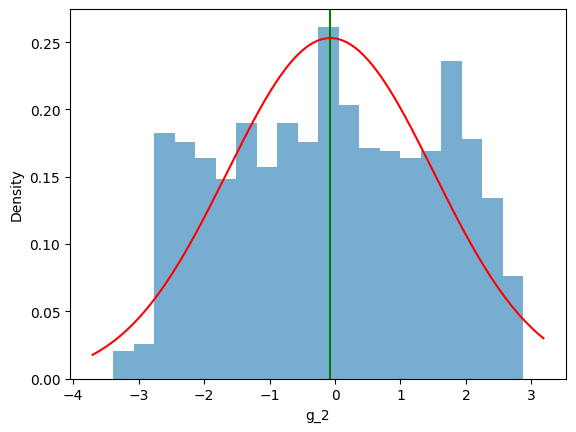

mean: 0.02705289444406762, std: +/-0.7470536094278547


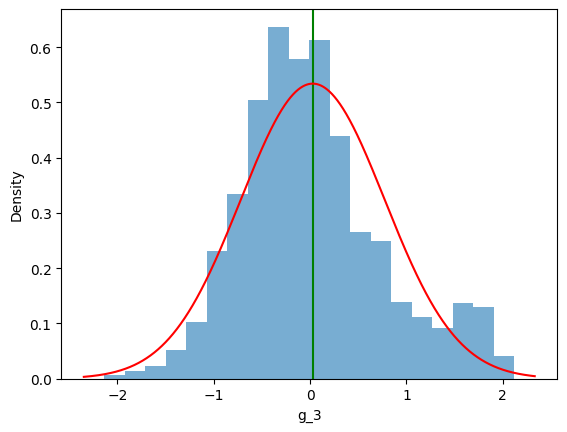

In [31]:
for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    plot_normal_distribution(name, data_series)

### Time-series Visualization

In [32]:
def time_series_plot(sensor_type, data):
    ''' Plot time-series visualization
    sensor_type: inertial sensor name, e.g. Accelerometer
    data: respective x, y, z component data in this array order
    '''
    # Takes first letter of sensor_type for the plot labelling
    prefix = sensor_type[0].lower()
    t = data['time']
    x = data[f'{prefix}_1']
    y = data[f'{prefix}_2']
    z = data[f'{prefix}_3']

    plt.figure(figsize=(10, 3))
    plt.plot(t, x, label='x')
    plt.plot(t, y, label='y')
    plt.plot(t, z, label='z')

    plt.title(sensor_type)
    plt.xlabel("time")
    plt.legend()
    plt.tight_layout()
    plt.show()

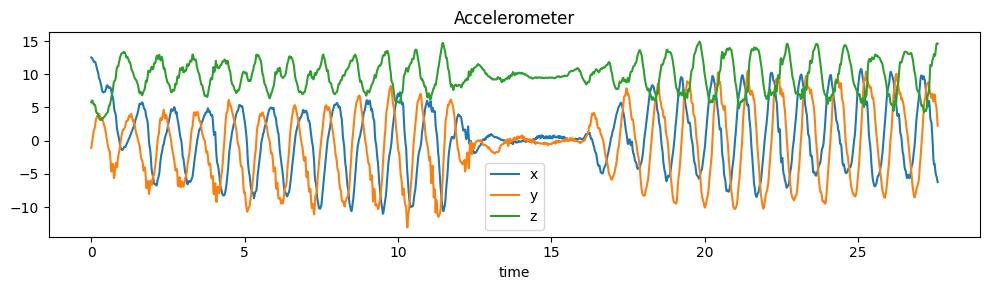

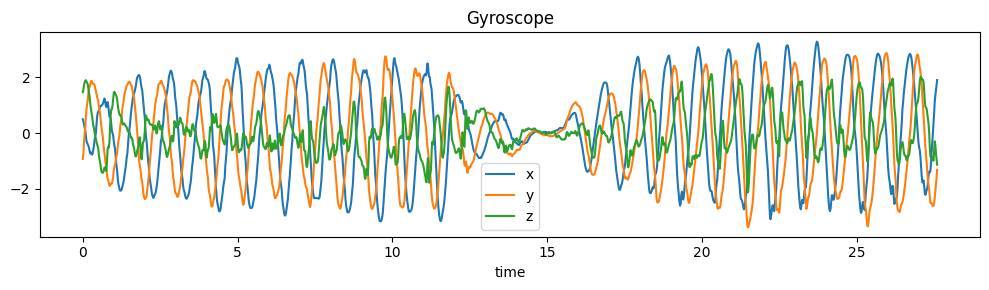

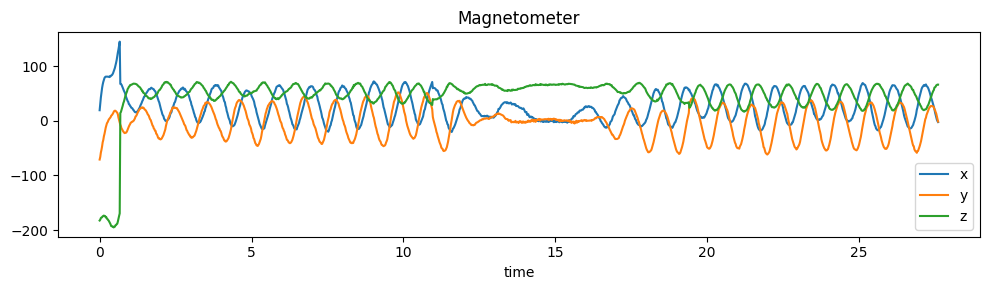

In [33]:
# df_sorted = df_filtered.sort_values('time', ascending=True)
time_series_plot('Accelerometer', df_filtered)
time_series_plot('Gyroscope', df_filtered)
time_series_plot('Magnetometer', df_filtered)

## Comparing Raw and Filtered Data
Note: May be best to compare model performance evaluation on raw data vs. filtered data. Raw data is technically not ideal and not the ground truth.

In [26]:
# Original, unfiltered
print('Original, unfiltered')

for name, data_series in df_unfiltered[df_unfiltered.columns[0:9]].items():
    _, _ = get_statistics(name, data_series)

Original, unfiltered

a_1 average mean: 10.928972769492754 +/- 1.8906667244686557

a_2 average mean: -2.7521712797155797 +/- 2.538101238977037

a_3 average mean: 2.9823934279952176 +/- 2.594125632558261

m_1 average mean: 60.88902004076087 +/- 9.053039008104967

m_2 average mean: -22.761390531086956 +/- 15.340873111432035

m_3 average mean: -12.45391564039058 +/- 33.36847181021336

g_1 average mean: -0.026045657078792275 +/- 0.8447284774578925

g_2 average mean: 0.0605175853177657 +/- 1.5259198330976687

g_3 average mean: -0.03899166365471014 +/- 1.6764546636550928


In [27]:
# After Madgwick Filter - is this directly comparable though? W.r.t exercise motion. I don't think it is.
print('After Madgwick Filter')

for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    _, _ = get_statistics(name, data_series)

After Madgwick Filter

a_1 average mean: 0.5051497729650866 +/- 4.894298924030102

a_2 average mean: -0.5714496677425848 +/- 5.275436698492464

a_3 average mean: 9.731769399286284 +/- 2.369309273181882

m_1 average mean: 27.10212525684255 +/- 26.542803808087506

m_2 average mean: -3.4970162747384674 +/- 26.869458795644455

m_3 average mean: 46.0734116191612 +/- 38.94229690116995

g_1 average mean: 0.04895847261936275 +/- 1.6746326427519291

g_2 average mean: -0.07011635023757262 +/- 1.5771569086616555

g_3 average mean: 0.027052894444067613 +/- 0.74732442821849


Original, unfiltered
mean: 10.928972769492754, std: +/-1.8899815761495575


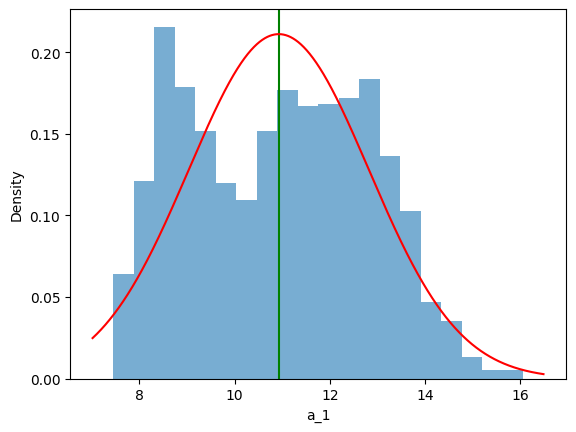

mean: -2.7521712797155797, std: +/-2.537181470423923


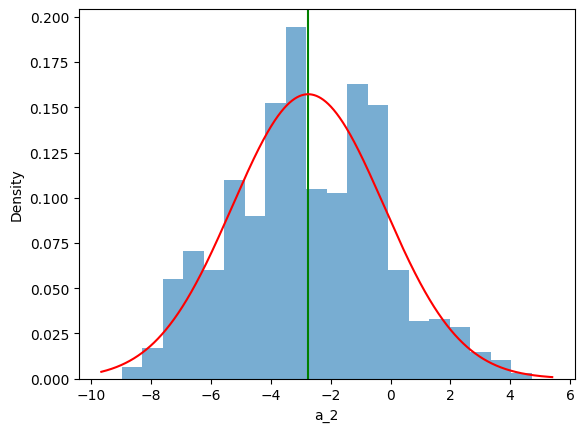

mean: 2.982393427995218, std: +/-2.5931855616331876


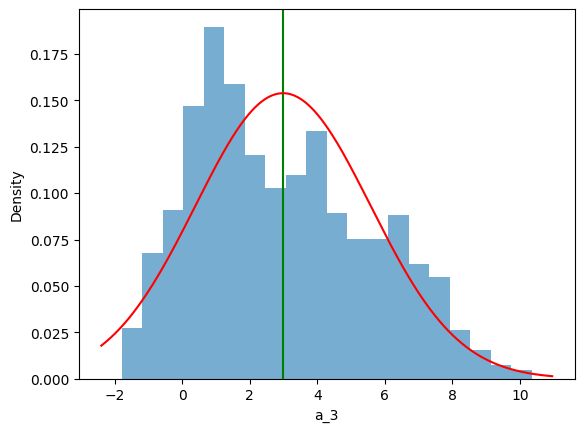

mean: 60.88902004076087, std: +/-9.049758327073848


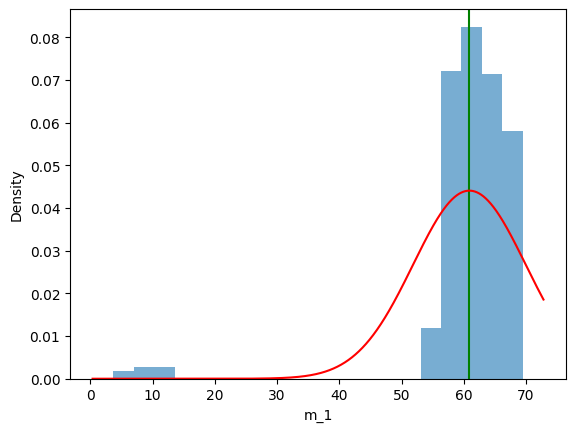

mean: -22.76139053108696, std: +/-15.335313816771707


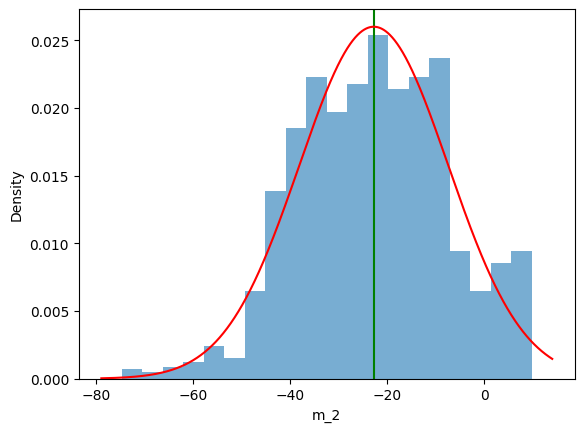

mean: -12.45391564039058, std: +/-33.35637959317914


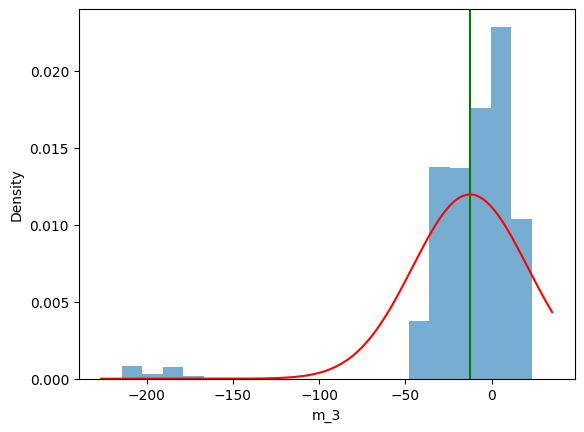

mean: -0.026045657078792254, std: +/-0.8444223609493962


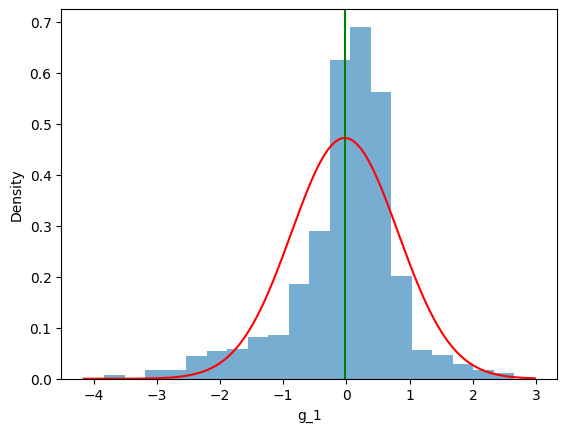

mean: 0.06051758531776571, std: +/-1.5253668633990987


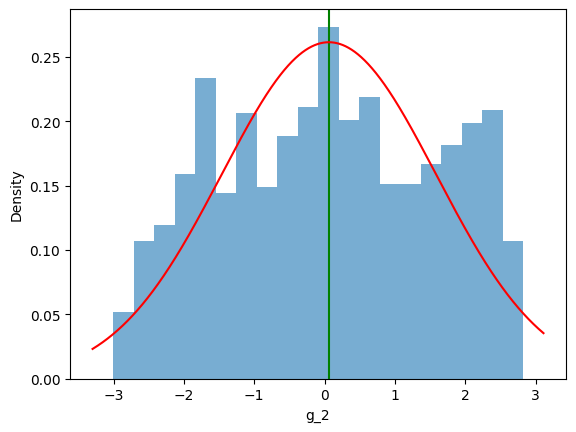

mean: -0.038991663654710136, std: +/-1.6758471424669412


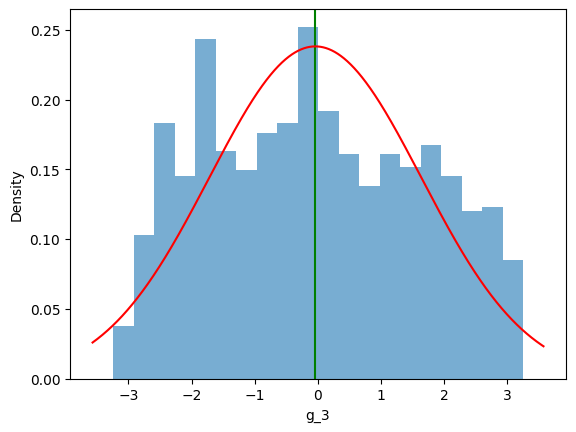

In [34]:
# Original, unfiltered
print('Original, unfiltered')

for name, data_series in df_unfiltered[df_unfiltered.columns[0:9]].items():
    plot_normal_distribution(name, data_series)

After Madgwick Filter
mean: 0.5051497729650865, std: +/-4.8925253059526455


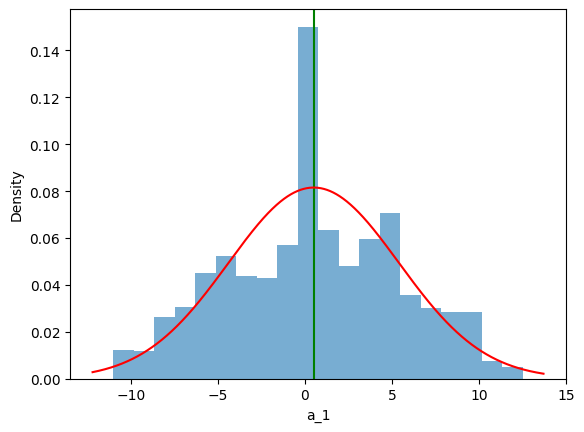

mean: -0.5714496677425848, std: +/-5.273524961992475


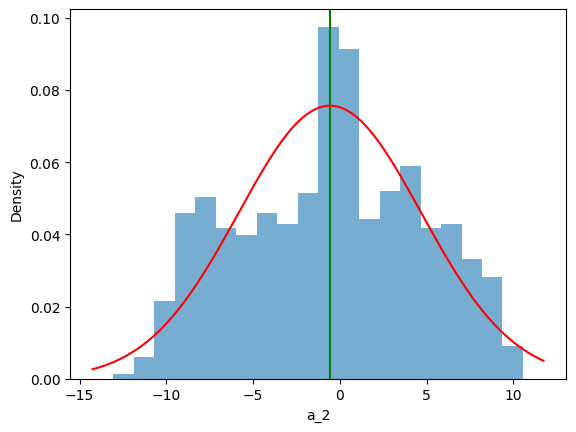

mean: 9.731769399286284, std: +/-2.3684506722212073


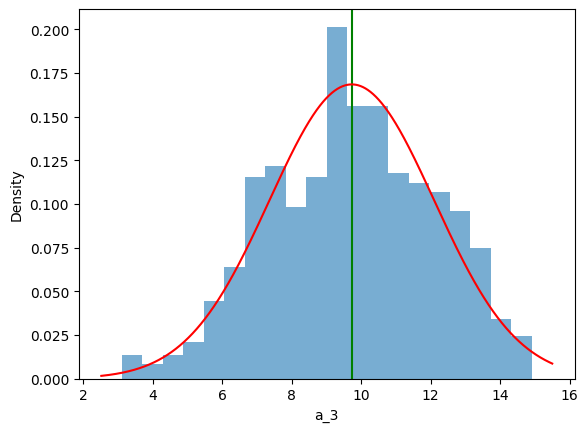

mean: 27.102125256842555, std: +/-26.533185107351986


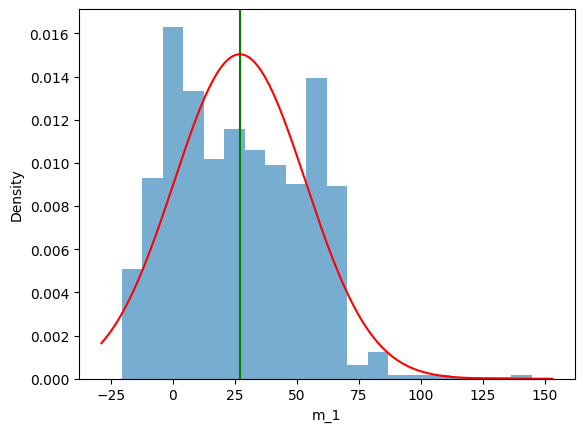

mean: -3.4970162747384674, std: +/-26.859721720203993


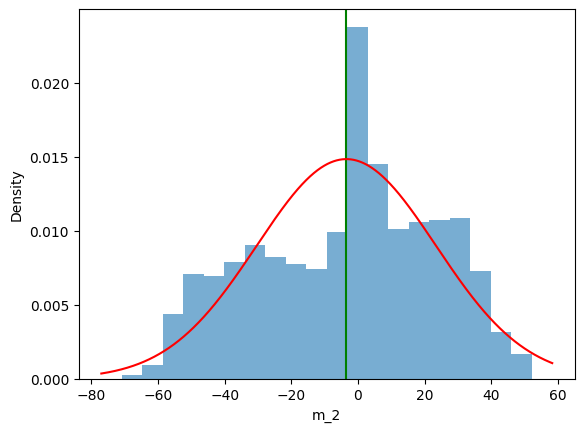

mean: 46.0734116191612, std: +/-38.92818481630679


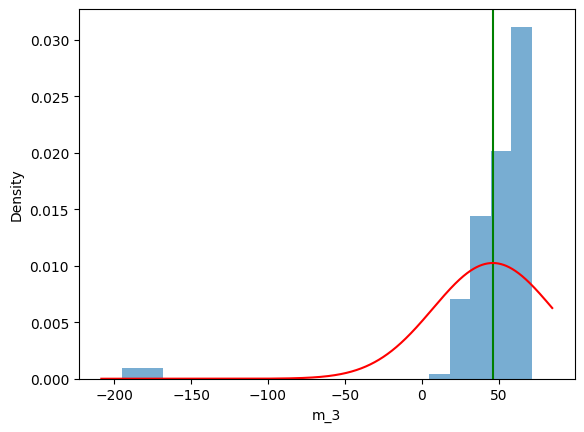

mean: 0.04895847261936275, std: +/-1.6740257818359148


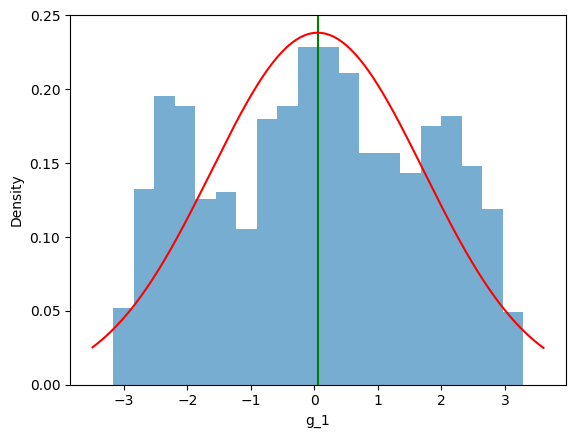

mean: -0.07011635023757262, std: +/-1.5765853714409814


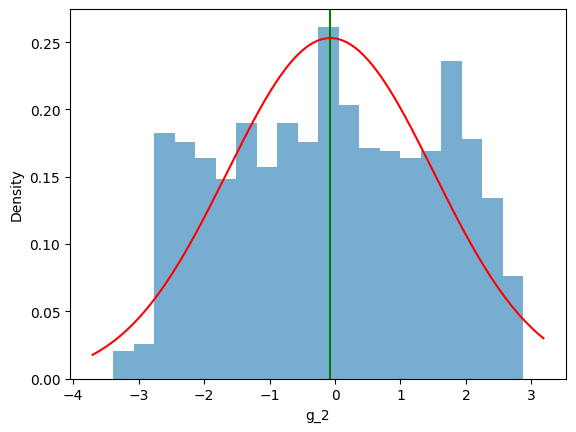

mean: 0.02705289444406762, std: +/-0.7470536094278547


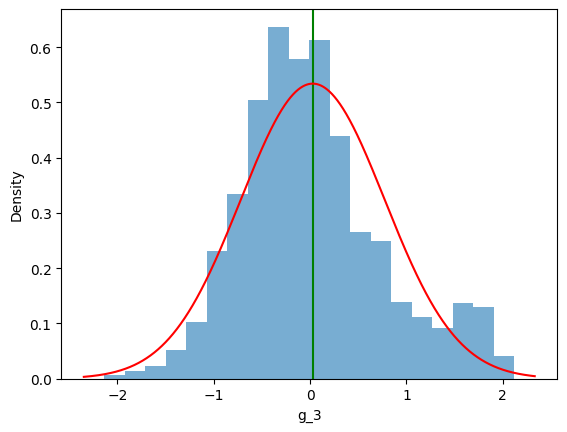

In [35]:
# After Madgwick Filter
print('After Madgwick Filter')

for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    plot_normal_distribution(name, data_series)

Unfiltered


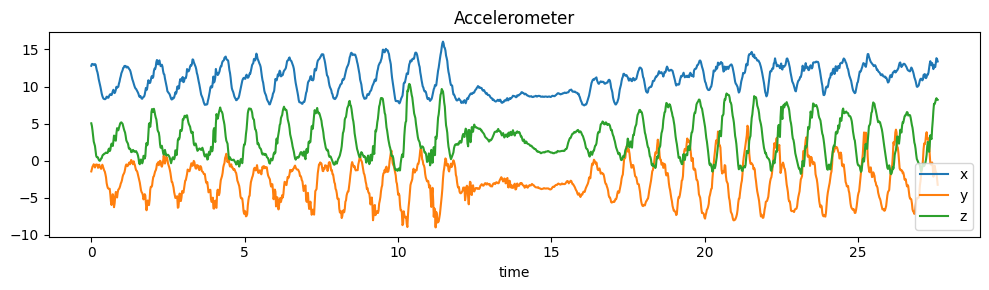

Filtered


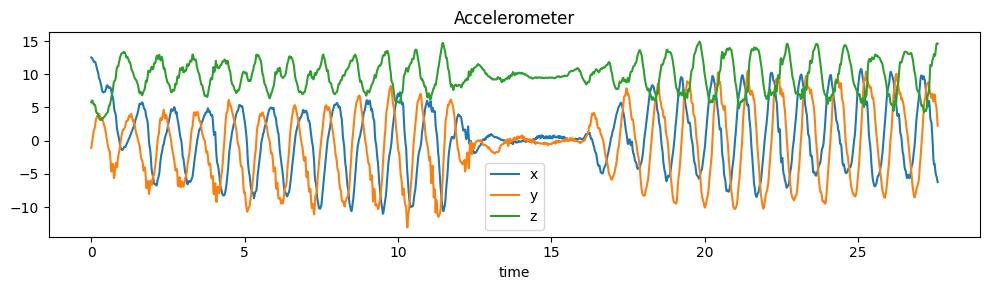

Unfiltered


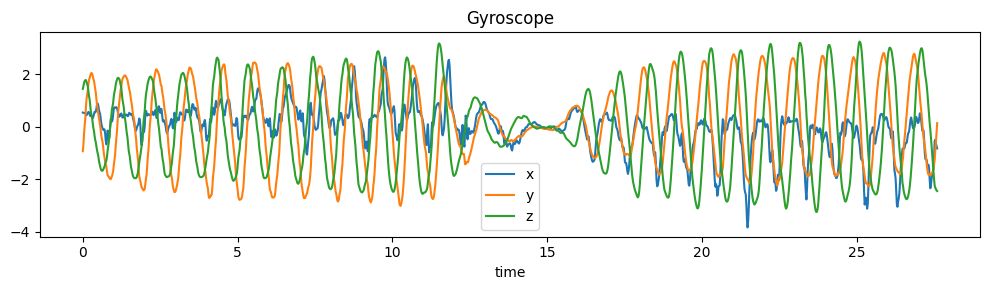

Filtered


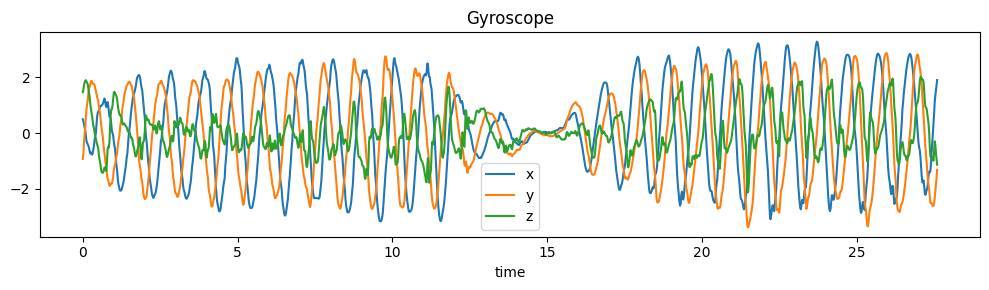

Unfiltered


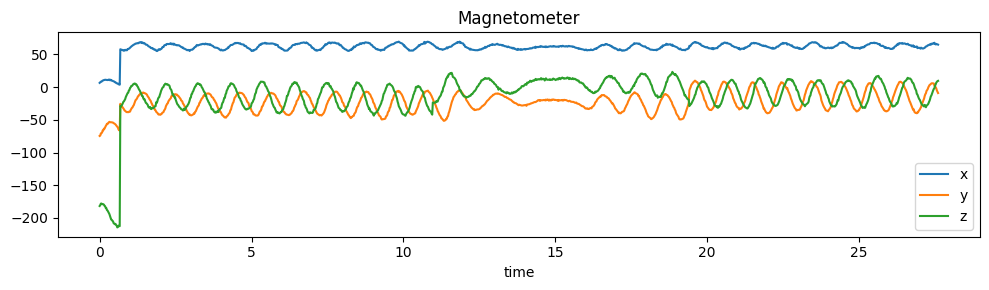

Filtered


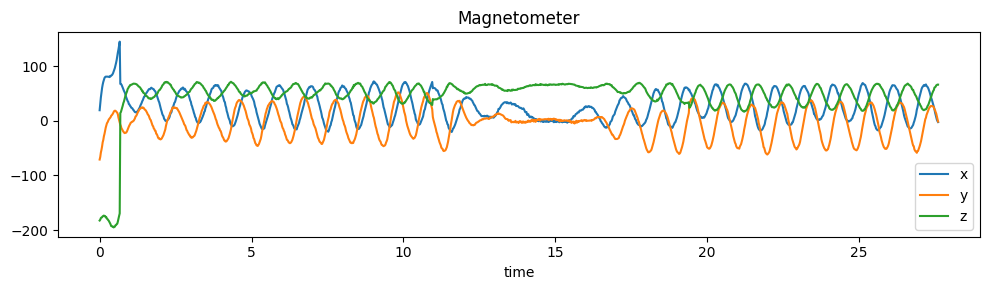

In [36]:
print('Unfiltered')
time_series_plot('Accelerometer', df_unfiltered)
print('Filtered')
time_series_plot('Accelerometer', df_filtered)
print('Unfiltered')
time_series_plot('Gyroscope', df_unfiltered)
print('Filtered')
time_series_plot('Gyroscope', df_filtered)
print('Unfiltered')
time_series_plot('Magnetometer', df_unfiltered)
print('Filtered')
time_series_plot('Magnetometer', df_filtered)

# Future Work: Extended Kalman Filter (EKF)
A potential library: [EKF GitHub](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/11-Extended-Kalman-Filters.ipynb)